# Survival analysis
BS Vương Kiến Thanh

Bài này sẽ nói về một loại data mới, đó là time-to-event, ví dụ như:
- Time from at risk to heart attack
- Time from at risk to cancer
- Time to death,...

Phân tích những data này gọi là survival analysis, phân tích sống còn.  

---
--- Skip phần này ---

In [1]:
# import các lib cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines as ll


# một số function lặp lại
def plot_time_to_evt():
    plt.barh(range(1,11), time_follow, height=0.2, left=time_attend)
    for i, v in enumerate(np.sum([time_attend, time_follow],axis=0)):
        plt.text(v,i+1, event[i])
    plt.gca().invert_yaxis()
    plt.xlabel('Years')
    plt.ylabel('Participants')
    plt.xticks(range(13))
    plt.yticks(range(1,11))
    
def plot_1_kmf(df, label=None, xlabel='month', ylabel='P(survival)'):
    kmf = ll.KaplanMeierFitter()
    kmf.fit(durations=df.iloc[:,0],
            event_observed=df.iloc[:,1],
            label=label)
    ax = kmf.plot()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax, kmf

def plot_2_kmf(df, xlabel='month', ylabel='P(survival)'):
    '''
    df: a 4-columns pd.DataFrame, with
        col0, col2: time to event
        col1, col3: event
    '''
    g_1 = df.columns[0][0]
    g_2 = df.columns[2][0]
    
    kmf = ll.KaplanMeierFitter()
    kmf.fit(durations=df.iloc[:,0],
            event_observed=df.iloc[:,1],
            label=g_1)
    ax = kmf.plot()
    kmf.fit(durations=df.iloc[:,2],
            event_observed=df.iloc[:,3],
            label=g_2)
    kmf.plot(ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax, kmf
    
def create_survival_table(df):
    df0_ = pd.concat([df.iloc[:,0], pd.Series(np.ones(len(df)))], axis=1)
    df0_.columns =['time to EVT', 'EVT']
    df1_ = pd.concat([df.iloc[:,1], pd.Series(np.zeros(len(df)))], axis=1)
    df1_.columns =['time to EVT', 'EVT']
    return pd.concat([df0_, df1_], axis=0).dropna().reset_index(drop=True)

def convert_to_survival(df):
    g_1 = df.columns[0][0]
    g_2 = df.columns[2][0]
    df1_ = create_survival_table(df[g_1]) 
    df2_ = create_survival_table(df[g_2]) 
    return pd.concat([df1_,df2_], axis=1, keys=[g_1,g_2])

def logrank(df):
    '''
    df: a 4-columns pd.DataFrame, with
        col0, col2: time to event
        col1, col3: event
    '''
    result= ll.statistics.logrank_test(durations_A=df.iloc[:,0],
                                       durations_B=df.iloc[:,2],
                                       event_observed_A=df.iloc[:,1],
                                       event_observed_B=df.iloc[:,3])
    result.print_summary()

--- end skip ---

---

# I. Một số đặc tính của time-to-event
- Phân phối bị skewed do time luôn luôn dương.
- Dữ liệu không đầy đủ do các đối tượng bị:
    - Mất liên lạc
    - Chết đột ngột do nguyên nhân khác ( nếu chết không phải event quan tâm)
    - Không bị event suốt thời gian nghiên cứu
- Khi đó, time-to-true-event bị che đậy, ( dài hơn time-to-event thu thập được), ngta gọi đó là censored time, hay chính xác hơn là right-censoring.

## Ví dụ:
Nghiên cứu 10 bệnh nhân trong 10 năm, theo dõi cơn đột quỵ tim.  
Bệnh nhân được cho mẫu nghiên cứu trong vòng 2 năm đầu và theo dõi 10 năm tiếp theo.  
Trong đó, một số bệnh nhân tham gia trễ.

In [2]:
time_attend = [1,0,2,0,1,1,0,2,0,1]
time_follow = [10,4,9,4,7,10,2,10,10,3]
event = ['free', 'MI', 'MI', 'dropout', 'MI', 'free', 'dropout', 'free', 'free', 'death']

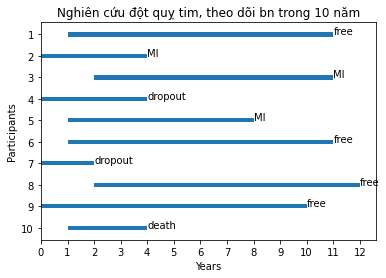

In [3]:
plot_time_to_evt()
plt.title('Nghiên cứu đột quỵ tim, theo dõi bn trong 10 năm');

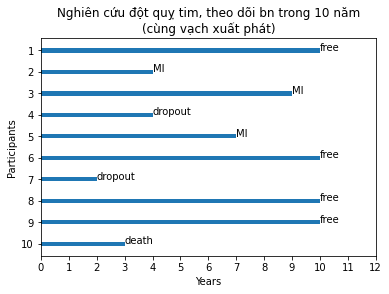

In [4]:
# làm cho cùng vạch xuất phát
time_attend = np.zeros(10)
plot_time_to_evt()
plt.title('Nghiên cứu đột quỵ tim, theo dõi bn trong 10 năm\n(cùng vạch xuất phát)');

Trong nghiên cứu này, P(MI) = 30%, tuy nhiên, data này bị censored, nên con số P này có thể thấp hơn sự thật. Hoặc nếu ta loại trừ 3 ca bị death và dropout, P(MI) = 3/7 = 43%, khác hoàn toàn với 30%. Kiểu tính tỉ lệ không áp được với data này.

Survival analysis tận dùng những **thông tin** time-to-event mà event chưa xảy ra, như DropOut, Death, EventFree,..  
Một trong những **tiền đề** để sử dụng data bị censored đó là **data bị censored độc lập với event.**  
Đây còn gọi là noninformative censoring.

Giả sử cùng nghiên cứu với 10 bn khác:

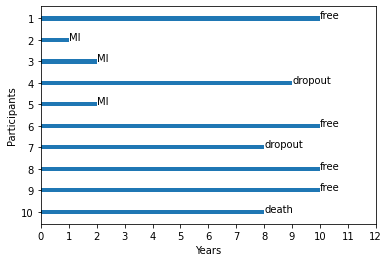

In [5]:
time_follow = [10,1,2,9,2,10,8,10,10,8]
plot_time_to_evt()

Tình huống này, ta nhận thấy, so với data cũ, event đột quỵ tim xảy ra sớm hơn, dropout và death xảy ra trễ hơn.  
Liệu P(MI) của data mới này có khác với data cũ?  
Trong survival analysis, ta không chỉ dùng số đối tượng bị event, mà còn thời để xảy ra event.

# II. Giới thiệu
Trong survival analysis, ta thu thập 2 loại dữ liệu.  
- Có xảy ra Event hay không, được coded là 1,0
- Thời gian tới Event, tính từ thời điểm bắt đầu có yếu tố nguy cơ, thường là thời điểm bắt đầu nghiên cứu.

Chúng ta dùng 2 loại data này để ước lượng một survival function.
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b3/Survival_function_1.svg/800px-Survival_function_1.svg.png' width=500 align='left'></img>

Tại thời điểm zero, xác suất sống là 100%, theo thời gian, P(sống) giảm dần.

Ta quan tâm thời điểm mà P(sống)=50%, gọi là **thời điểm trung vị sống còn**, ví dụ như hình là P(sống | time=1.5 month) = 50%

Survival function có thể là step function (hình bậc thang)

# III. Kaplan Meier, một trong những pp tìm đường cong sống còn
<img src="https://upload.wikimedia.org/wikipedia/commons/7/73/Km_plot.jpg" align='left'></img>
Xác suất sống còn tại thời điểm origin = 1,  
Xác suất sống còn tại thời điểm t+1 =

$$S(t+1) = S(t) \times \frac{N_{t+1} - D_{t+1}}{N_{t+1}}$$
- N: số lượng mẫu còn lại sau khi trừ Death và Censor
- D: số lượng Death
- S: Survival function

Có thể tính khoảng tin cậy bằng *pp Greenwood*, *Exponential*.

## Ví dụ:
Nghiên cứu thời gian đên tử vong ở 20 người >=65t, theo dõi trong 24 tháng.

In [6]:
df = pd.DataFrame(np.array([[24,3,11,19,24,13,14,2,18,17,24,21,12,1,10,23,6,5,9,17],
                  [0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1]]).T,
                 index=range(1,21),
                 columns=['Time to event', 'Death'])
df.index.name='Participant ID'
df.head()

,Time to event,Death
Participant ID,,
1,24,0
2,3,1
3,11,0
4,19,0
5,24,0


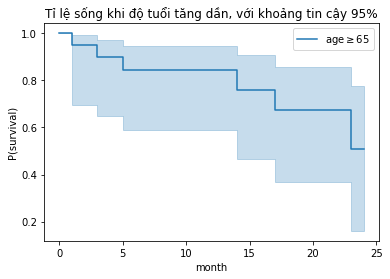

In [7]:
ax,kmf = plot_1_kmf(df,label=r'age$\geq$65')
ax.set_title('Tỉ lệ sống khi độ tuổi tăng dần, với khoảng tin cậy 95%');

In [9]:
# trung vị sống còn
kmf.median_survival_time_
# inf là infinity, ở đây là 24 tháng.

inf

In [10]:
kmf.confidence_interval_.head()

,age$\geq$65_lower_0.95,age$\geq$65_upper_0.95
0.0,1.000000,1.000000
1.0,0.694743,0.992802
2.0,0.694743,0.992802
3.0,0.647529,0.973299
5.0,0.591142,0.947073


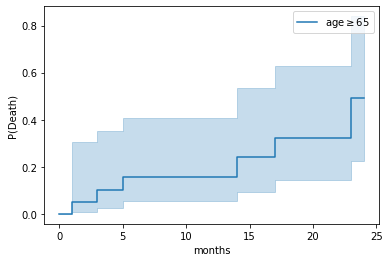

In [11]:
# Một số ng thích vẽ ngược lại
ax = kmf.plot_cumulative_density()
ax.set_xlabel('months')
ax.set_ylabel("P(Death)");

In [12]:
# P( Survival | 15 months)
kmf.predict(15)

0.76

In [13]:
# P( Death | 15 months) = 1 - p(survival|15months)
1 - kmf.predict(15)

0.24

# IV. KMF 2 nhóm: so sánh 2 survival bằng đồ hoạ

## Ví dụ:
Một trial trên 20 bn K dạ dày stage 4.  
Họ được ngẫu nhiên gán vào 2 nhóm: hoá trị trước phẫu thuật, và hoá trị sau phẫu thuật.  
Outcome là Death, theo dõi trong 48 tháng

In [14]:
cols = [['Chemotherapy Before Surgery','Chemotherapy After Surgery'],
        ['Month of Death', 'Month of Last Contact']]
df2 = pd.DataFrame(np.array([[8, 12, 26, 14,    21,     27,     np.nan],
                            [ 8, 32, 20, 40,    np.nan, np.nan, np.nan],
                            [33, 28, 41, np.nan,np.nan, np.nan, np.nan],
                            [48, 48, 25, 37,    48,     25,     43]]).T,
                   columns=pd.MultiIndex.from_product(cols)
                  )
df2.replace(np.nan,"").style.hide_index().set_precision(0)

In [15]:
df2 = convert_to_survival(df2)
df2

Chemotherapy Before Surgery      Chemotherapy After Surgery     
                  time to EVT  EVT                time to EVT  EVT
0                         8.0  1.0                       33.0  1.0
1                        12.0  1.0                       28.0  1.0
2                        26.0  1.0                       41.0  1.0
3                        14.0  1.0                       48.0  0.0
4                        21.0  1.0                       48.0  0.0
5                        27.0  1.0                       25.0  0.0
6                         8.0  0.0                       37.0  0.0
7                        32.0  0.0                       48.0  0.0
8                        20.0  0.0                       25.0  0.0
9                        40.0  0.0                       43.0  0.0

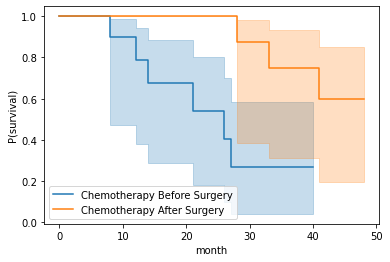

In [16]:
ax, kmf2 = plot_2_kmf(df2)

Ta thấy rằng xác suất sống của nhóm hoá trị sau phẫu thuật cao hơn hẳn.  
Tuy nhiên, do vấn để cỡ mẫu nhỏ, power không cao, vậy xác suất sống của 2 nhóm khác nhau có significant không?

# V. Log rank test: so sánh 2 survival bằng test
Ta dùng log rank test để thử significance của sự khác nhau của 2 survival functions.

## Dùng ví dụ trên:

In [17]:
logrank(df2)

**Với pval=0.01<0.05, ta kết luận 2 nhóm có survival function khác nhau có ý nghĩa thống kê.**

## Ví dụ:
Một nghiên cứu về hiệu quả của một can thiệp nhỏ để hạn chế rượu ở phụ nữ thai 18 tuần.  
n=16 phụ nữ nghiện rượu mang thai 18w, được ngẫu nhiên lựa chọn để sử dụng can thiệp.  
Outcome là thời gian bắt đầu nghiên cứu đến lần dùng lại rượu đầu tiên, hoặc alcohol free lúc kết thúc nghiên cứu.  
Thời gian kết thúc là thai 39w.

In [18]:
cols2 = [['Standard Prenatal Care','Brief Intervention'],
        ['Relapse', 'No Relapse']]
df3 = pd.DataFrame(np.array([[19, 6, 5, 4, np.nan],
                            [ 20, 19,17,14, np.nan],
                            [16, 21, 7, np.nan, np.nan],
                            [21,15,18,18,5]]).T,
                   columns=pd.MultiIndex.from_product(cols2)
                  )
df3.replace(np.nan,"").style.hide_index().set_precision(0)

In [19]:
df3 = convert_to_survival(df3)
df3

Standard Prenatal Care      Brief Intervention     
             time to EVT  EVT        time to EVT  EVT
0                   19.0  1.0               16.0  1.0
1                    6.0  1.0               21.0  1.0
2                    5.0  1.0                7.0  1.0
3                    4.0  1.0               21.0  0.0
4                   20.0  0.0               15.0  0.0
5                   19.0  0.0               18.0  0.0
6                   17.0  0.0               18.0  0.0
7                   14.0  0.0                5.0  0.0

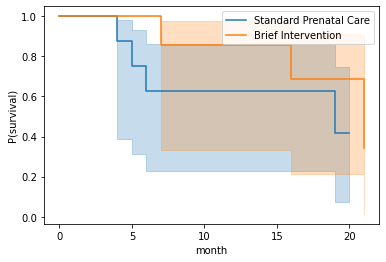

In [20]:
ax, kmf3 = plot_2_kmf(df3)

In [21]:
logrank(df3)

**Với pval=0.36, 2 survival function khác nhau không có significant.**

<div class="alert alert-block alert-info">
    <b>Note:</b> <a href="https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html"> Trong đây </a>có nói log rank test có rất nhiều khuyết điểm, dùng cox regression tốt hơn nhiều.</br>
    <b>Như:</b><ul>
    <li>log-rank test does not work for continuous exposures</li>
    <li>it does not allow for covariate adjustment</li>
    <li>the usual P-value from log-rank may not be as accurate as the likelihood ratio χ2 statistic from Cox PH</li>
    </ul>
</div>

# VI. Cox Proportional Hazards Regression: PP hiện đại, đa biến, có thể predict data mới

Tương tự như Linear/Logistic Regression, Cox Regression cho nhập nhiều tham số để tính ra survival function.  
Trong đó:
- y: hazard rate
- hazard rate: là một con số dương có thể lớn hơn 1, là số event ước tính trong một đơn vị thời gian
    - Ví dụ: hazard rate =0.2/1 tháng, tức là 0.2 event có thể xảy ra trên mỗi người trong một tháng.
    - Tức là mỗi người có 1/0.2 = 5 tháng event-free

Chúng ta thường so sánh các nhóm với nhau bằng hazard ratio, tương tự như odds ratio trong logistic regression.

$$\underbrace{h(t | x)}_{\text{hazard}} = \overbrace{b_0(t)}^{\text{baseline hazard}} \underbrace{\exp \overbrace{\left(\sum_{i=1}^n b_i (x_i - \overline{x_i})\right)}^{\text{log-partial hazard}}}_ {\text{partial hazard}}$$

Nếu $X_i$ là biến continuous:
- Hệ số $b_i$ tại $X_i$: khi tăng 1 đơn vị t thì  hazard rate tăng $exp(b_i)$  
Nếu $X_i$ là biến nhị phân:
- Hazard ratio  = $exp(b_i)$ 
- Hazard ratio ~ 1 thì $X_i$ không ảnh hưởng đến survival.  
- Hazard ratio < 1 thì $X_i$ là một yếu tố tốt, làm giảm hazard rate
- Ngược lại, Hazard ratio > 1 thì $X_i$ là một yếu tố xấu, làm tăng hazard rate

Cox Regression không mặc định baseline hazard phân phối theo bất kỳ phân phối nào.  
Những regression khác:
- Exponential: hazard rate cố định
- Weibull, Gompertz, and lognormal distributions: hazard rate tăng theo t, giảm theo t, tăng lên rồi giảm xuóng,..

In [31]:
# data là  Telco-Customer-Churn data set, Kaggle
# đo thời gian sử dụng dịch vụ cho tới lúc dừng dịch vụ
# tenure la thoi gian su dung (months)
# churn là dừng sử dụng

df_c = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", usecols=[1, 5,12,13,18, 20])

df_c.replace('Yes', 1, inplace=True)
df_c.replace('No', 0, inplace=True)
df_c.replace('No internet service', 0, inplace=True)
df_c.replace('Male', 1, inplace=True)
df_c.replace('Female', 0, inplace=True)

#df_z['Churn'].co
df_c.describe()

,gender,tenure,TechSupport,StreamingTV,MonthlyCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,32.371149,0.290217,0.384353,64.761692,0.265370
std,0.500013,24.559481,0.453895,0.486477,30.090047,0.441561
min,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,0.000000,0.000000,35.500000,0.000000
50%,1.000000,29.000000,0.000000,0.000000,70.350000,0.000000
75%,1.000000,55.000000,1.000000,1.000000,89.850000,1.000000
max,1.000000,72.000000,1.000000,1.000000,118.750000,1.000000


In [36]:
cox = ll.CoxPHFitter()
cox.fit(df_c,
        duration_col='tenure',
        event_col='Churn',
        show_progress=True)

Iteration 1: norm_delta = 0.78892, step_size = 0.9500, log_lik = -15653.03964, newton_decrement = 330.60997, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.09030, step_size = 0.9500, log_lik = -15318.88850, newton_decrement = 6.14838, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01067, step_size = 0.9500, log_lik = -15312.55268, newton_decrement = 0.07251, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00008, step_size = 1.0000, log_lik = -15312.47980, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -15312.47980, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [37]:
cox.print_summary()

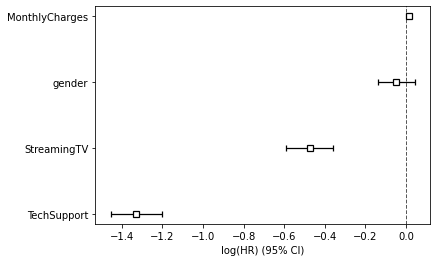

In [39]:
cox.plot()

**Hai yếu tố quan trọng là StreamingTV và Techsupport, hệ số âm tức là stream nhiều với cần support nhiều là hazard rate nhỏ.**  
**Gender thì pval=0.31, không có significant.**  
**MonthlyCharges: hệ số quá nhỏ mặc dù significant, có thể có vì nó quá dao động và biên độ lớn.**

In [38]:
cox.baseline_hazard_.head()

,baseline hazard
0.0,0.000000
1.0,0.045050
2.0,0.016152
3.0,0.012918
4.0,0.011826


In [87]:
# survival function ở 
# a. nam, có techsupport và streamtv, tháng 50$
# b. nữ, không techsupport và không stream, tháng 20$
data = np.array([[1,1,1,50], [0,0,0,20]])
cox.predict_survival_function(data)

,0,1
0.0,1.000000,1.000000
1.0,0.990026,0.961928
2.0,0.986475,0.948634
3.0,0.983643,0.938134
4.0,0.981058,0.928623
...,...,...
68.0,0.909679,0.693106
69.0,0.907242,0.685941
70.0,0.903394,0.674745
71.0,0.900875,0.667488


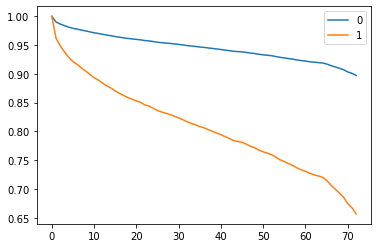

In [88]:
cox.predict_survival_function(data).plot()

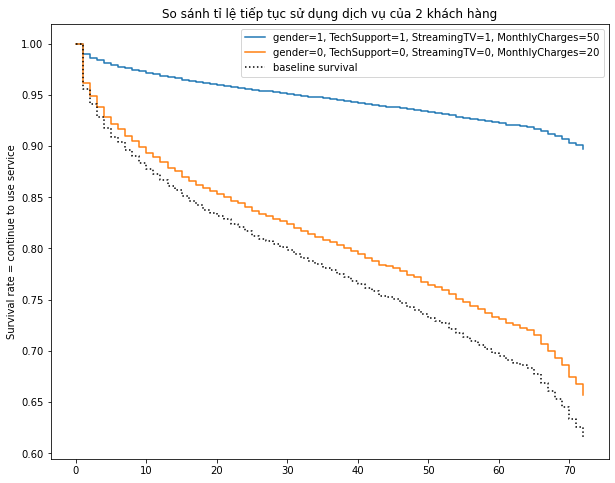

In [89]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
cox.plot_covariate_groups(['gender','TechSupport', 'StreamingTV','MonthlyCharges'],
                         values=data,
                         ax=ax)
ax.set_ylabel('Survival rate = continue to use service')
ax.set_title('So sánh tỉ lệ tiếp tục sử dụng dịch vụ của 2 khách hàng');

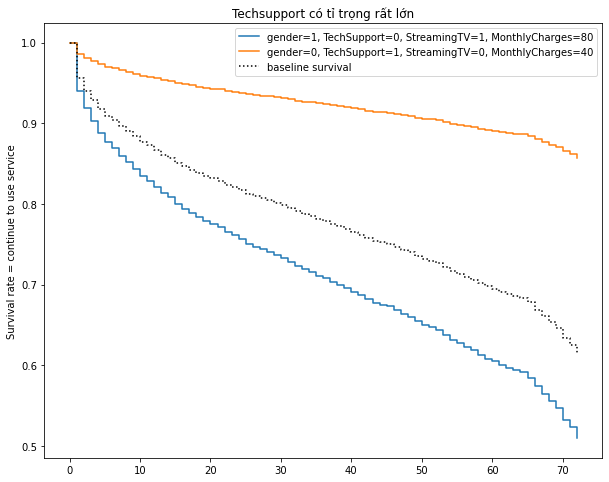

In [90]:
# survival function ở 
# a. nam, k techsupport và co streamtv, tháng 80$
# b. nữ, co techsupport và không stream, tháng 60$
data2 = np.array([[1,0,1,80], [0,1,0,40]])
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
cox.plot_covariate_groups(['gender','TechSupport', 'StreamingTV','MonthlyCharges'],
                         values=data2,
                         ax=ax)
ax.set_ylabel('Survival rate = continue to use service')
ax.set_title('Techsupport có tỉ trọng rất lớn');

# VII. Mở rộng:
- Chúng ta có thể đặt hệ số $b_i$ thay đổi theo thời gian. Khi ấy, tính toán sẽ phức tạp hơn nhiều. (CoxTimeVaryingFitter)
- Một trong những mặc định của cox regression là effect của risk factor không thay đổi, tức là hazard đồng dạng theo thời gian.
- So sánh các risk factors trong từng outcome với nhau, khi có nhiều outcome mà chúng có correlation.